## Setup and data cleaning, plus transdiagnostic factor derivation

### Setup

**Import Python dependencies**

In [1]:
import pandas as pd
import joblib, os, rpy2
os.chdir('..')
    # as the wd will be the notebook folder otherwise
%load_ext rpy2.ipython
    # warnings about 'quartz' on Windows can be safely ignored.

pal = ['#ffa630', '#42bfdd', '#ef3e36', '#745296','#f08080','#d17a22']
light_pal = ['#ffc9b5', '#b1ddf1', '#7871aa']

C:\JupyterLab\resources\jlab_server\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


### Import and clean raw data

In [101]:
%%R
devtools::load_all()

# single <- pstpipeline::import_single("data/example_res_single.txt", plot = TRUE, add_sex= TRUE)
# multiple <- pstpipeline::import_multiple("data/example_res_multiple.txt", separate = FALSE, indiv = TRUE)
# plot_id1 <- pstpipeline::plot_single(subjID = 1, multiple)

# all_res_split <- pstpipeline::import_multiple("data/all_995_complete.txt", add_sex = TRUE)
## this is very slow so not worth doing each time! just kept for clarity

# saveRDS(all_res_split, "data/all_res_split.RDS")

i Loading pstpipeline


### Calculate factor scores using model fit previously

**Write and load questionnaire data, and import classifier**

In [3]:
%%R
all_res_split <- readRDS("data/all_res_split.RDS");
# readr::write_csv(
#   dplyr::bind_rows(
#     all_res_split$non_distanced$gillan_questions,
#     all_res_split$distanced$gillan_questions
#   ),
#   "data/factor_prediction/questionnaire_subset_all_935.csv"
# );

In [3]:
questionnaire_likert = pd.read_csv('data/factor_prediction/questionnaire_subset_all_935.csv')
clf = joblib.load('data/factor_prediction/gillan_classifier_78.pkl')

**Predict factor scores in all participants**

In [4]:
factor_score_pred = clf.predict(questionnaire_likert.iloc[:, 1:])
factor_score_pred = pd.DataFrame(factor_score_pred, columns=['AD', 'Compul', 'SW'])
factor_score_pred.loc[:, 'subjID'] = questionnaire_likert['subjID'].values

factor_score_pred.head()
# factor_score_pred.to_csv('data/factor_prediction/all_935_predicted_factor_scores.csv')

,AD,Compul,SW,subjID
0,2.433235,2.530141,2.251934,5b2a2d855b5c0900018b0bf5
1,3.984658,3.717348,1.664801,5ee93e0226f9f0167b877dbe
2,1.960317,1.586168,1.295876,5f5121371ed01f30b8051b73
3,3.512113,2.449905,1.889159,5f22f8d8e7195104928f837f
4,3.471570,3.412705,1.413577,5ef20e5fa9ac1301228a263a


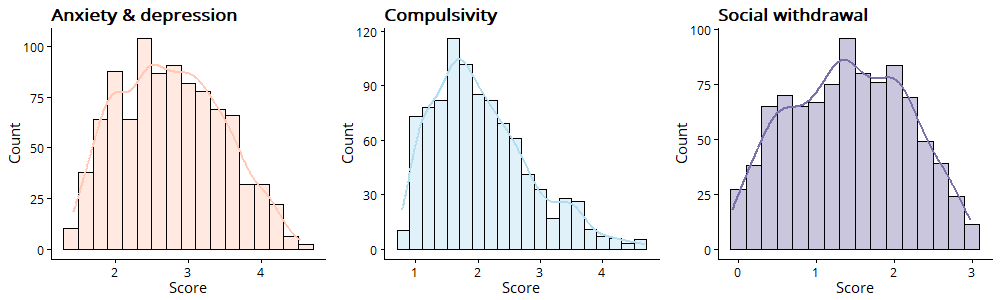

In [108]:
%%R -i factor_score_pred -i light_pal -w 10 -h 3 --units in -r 100

factors = names(factor_score_pred[,1:3])
factor_names = c('Anxiety & depression', 'Compulsivity', 'Social withdrawal')

pstpipeline::plot_factors(factor_score_pred, plot_type = "factor_hist", factors, factor_names, 
                          pal = light_pal, font_size = 11, font = "Open Sans")

# ggplot2::ggsave('notebooks/plots/all_935_factor_scores.png', device = "png")

**How do these distributions compare to those originally obtained by [Gillan et al (2016)](https://elifesciences.org/articles/11305)?**

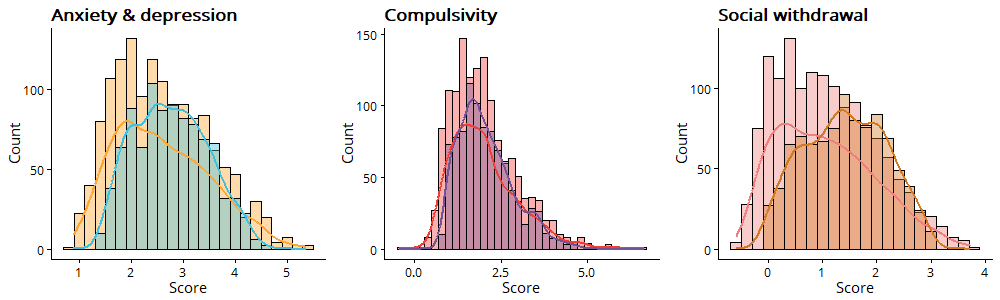

In [106]:
%%R -i factor_score_pred -i pal -w 10 -h 3 --units in -r 100

factor_scores <- factor_score_pred %>%
    dplyr::mutate(dataset = "Our data")
    
all_factor_scores <- read.csv('data/factor_prediction/gillan_scores.csv')[-1] %>%
    dplyr::rename(Compul = CIT) %>%
    dplyr::mutate(dataset = "Gillan et al., 2016") %>%
    dplyr::bind_rows(factor_scores)

pstpipeline::plot_factors(all_factor_scores, plot_type = "factor_hist", factors, factor_names, 
                          pal = pal, group = "dataset", font_size = 11, font = "Open Sans")

# ggplot2::ggsave('notebooks/plots/gillan2016_factor_scores.png', device = "png")

Scores for the "Compulsivity" factor seem relatively close to that seen in the study by [Gillan et al (2016)](https://elifesciences.org/articles/11305), while scores for the "Anxiety/Depression" factor are slightly higher. This may be explained by our aim to actively recruit a sample which included a similar proportion of individuals reporting a psychiatric diagnosis (past or present) to the UK population. Scores for the "Social Withdrawal" were notably higher than those seen in the original dataset; this may be partly confounded by the fact that data collection occurred in April-May 2021, when the UK was not yet fully out of lockdown restrictions.